In [14]:
import glob
import os
import json
import pickle
import yaml
import math

import uproot

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import sys
sys.path
sys.path.append("../python/")

import utils

plt.rcParams.update({"font.size": 20})

In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
# get lumi
with open("../fileset/luminosity.json") as f:
    luminosity = json.load(f)
    
luminosity

{'ele': {'Run2': 137640.0,
  '2016APV': 19492.72,
  '2016': 16809.96,
  '2017': 41476.02,
  '2018': 59816.23},
 'mu': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'lep': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'had': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96}}

In [17]:
full_lumi = luminosity["lep"]["Run2"]
full_lumi = full_lumi/1000
full_lumi

137.64

In [171]:
# get lumi
import pickle as pkl
with open("../combine/templates/v5/hists_templates_Run2.pkl", "rb") as f:    
    h = pkl.load(f)

In [172]:
h

Hist(
  StrCategory(['VBF', 'Data', 'EWKvjets', 'WH', 'WJetsLNu', 'TTbar', 'SingleTop', 'ggF', 'WZQQorDYJets', 'Diboson', 'QCD', 'ttH', 'ZH'], growth=True, name='Sample'),
  StrCategory(['nominal', 'weight_pdf_acceptance_up', 'weight_pdf_acceptance_down', 'weight_qcd_scale_up', 'weight_qcd_scale_down', 'weight_btagSFlightCorrelated_up', 'weight_btagSFlightCorrelated_down', 'weight_btagSFbcCorrelated_up', 'weight_btagSFbcCorrelated_down', 'weight_btagSFlight2016_up', 'weight_btagSFlight2016_down', 'weight_btagSFbc2016_up', 'weight_btagSFbc2016_down', 'weight_btagSFlight2016APV_up', 'weight_btagSFlight2016APV_down', 'weight_btagSFbc2016APV_up', 'weight_btagSFbc2016APV_down', 'weight_btagSFlight2017_up', 'weight_btagSFlight2017_down', 'weight_btagSFbc2017_up', 'weight_btagSFbc2017_down', 'weight_btagSFlight2018_up', 'weight_btagSFlight2018_down', 'weight_btagSFbc2018_up', 'weight_btagSFbc2018_down', 'weight_pileup_up', 'weight_pileup_down', 'weight_pileupIDSF_up', 'weight_pileupIDSF_down'

In [174]:
h[{"Sample": "ZH", "Region": "ggFpt250to300", "Systematic": "weight_pdf_acceptance_down"}].values()

array([0.    , 0.0002, 0.    , 0.0004, 0.0003, 0.0001, 0.    , 0.    ,
       0.    ])

In [156]:
h5[{"Sample": "ggF", "Region": "ggFpt250to300", "Systbematic": "nominal"}].values()

array([0.28980791, 0.81729663, 1.35315791, 1.83979604, 1.28377742,
       0.54206547, 0.35555107, 0.14995766, 0.03128985])

In [157]:
    systs_from_parquets = {
        # systematics applied on all samples
        "weight_pileup": (20, ["a", "b"]),
        "weight_pileupIDSF": (15, ["a", "b", "c"]),
    }

In [162]:
for sys_name, (sys_value, list_of_samples) in systs_from_parquets.items():
    break

In [163]:
sys_name

'weight_pileup'

In [164]:
list_of_samples

['a', 'b']

In [89]:
print("qcdscaleU_op:\n", h[{"Sample": "ggF", "Region": "ggFpt250to300", "Systematic": "weight_scale_up"}].values(), "\n")
print("nominal:\n", h[{"Sample": "ggF", "Region": "ggFpt250to300", "Systematic": "nominal"}].values(), "\n")
print("qcdscaleDown:\n", h[{"Sample": "ggF", "Region": "ggFpt250to300", "Systematic": "weight_scale_down"}].values(), "\n")

print("pdfaccUp:\n", h[{"Sample": "ggF", "Region": "ggFpt250to300", "Systematic": "weight_pdf_up"}].values(), "\n")
print("nominal:\n", h[{"Sample": "ggF", "Region": "ggFpt250to300", "Systematic": "nominal"}].values(), "\n")
print("pdfaccDown:\n", h[{"Sample": "ggF", "Region": "ggFpt250to300", "Systematic": "weight_pdf_down"}].values(), "\n")

qcdscaleU_op:
 [0.36004137 1.00624816 1.67443126 2.26857833 1.57886014 0.67783259
 0.44240108 0.18546446 0.0407048 ] 

nominal:
 [0.28980791 0.81729663 1.35315791 1.83979604 1.28377742 0.54206547
 0.35555107 0.14995766 0.03128985] 

qcdscaleDown:
 [0.23186242 0.65630718 1.0867773  1.47940799 1.03528552 0.43209868
 0.28591321 0.12020595 0.02450695] 

pdfaccUp:
 [0.57961582 1.63459325 2.70631582 3.67959207 2.56755485 1.08413094
 0.71110214 0.29991533 0.06257969] 

nominal:
 [0.28980791 0.81729663 1.35315791 1.83979604 1.28377742 0.54206547
 0.35555107 0.14995766 0.03128985] 

pdfaccDown:
 [0. 0. 0. 0. 0. 0. 0. 0. 0.] 



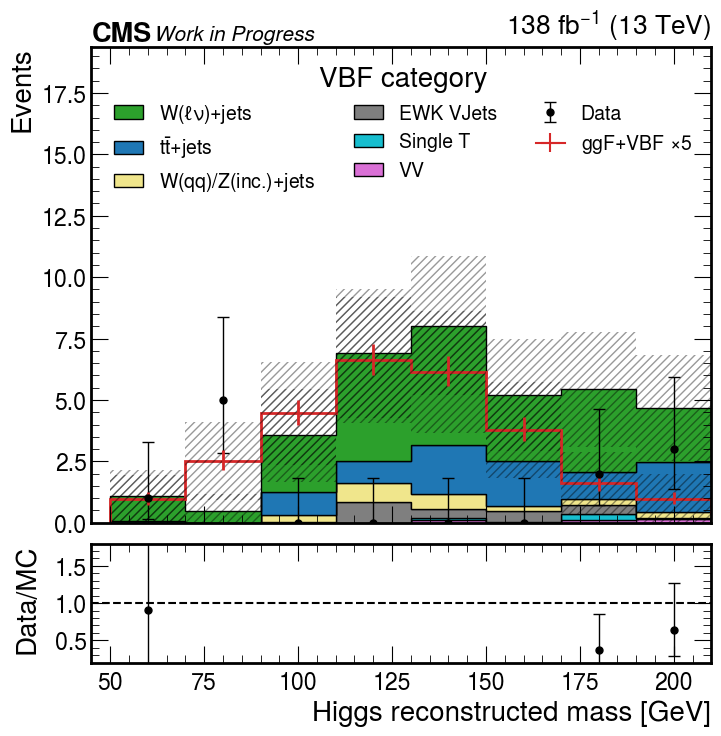

In [494]:
ch = "ele"

region = f"VBF965{ch}"
text = "VBF category"

# region = f"ggF975pt250to300{ch}"
# text = r"ggF $p_T$ $\in$ [250, 300]"

# region = "ggF975pt300to450"
# text = r"ggF $p_T$ $\in$ [300, 450]"

# region = "ggF975pt450toInf"
# text = r"ggF $p_T$ $\in$ [450, Inf]"

# region = "TopCR"
# text = "Top control region"

# region = "WJetsCR"
# text = "WJets control region"

plt.rcParams.update({"font.size": 20})
add_data = True


# if region.startswith("SR"):
add_soverb=True
blind_region=[90,160]
if "VBF" in region:
    mult=5
else:
    mult=10
# else:
#     add_soverb=True
#     blind_region=None
#     blind_region=[90,160]
#     mult=1

if "CR" in region:
    blind_region = False
    mult=1


years = ["2018", "2017", "2016", "2016APV"]
channels = ["ele", "mu"]

from utilsCombine import plot_hists
from utilsCombine2 import plot_hists

plot_hists(h[region][{"Systematic": "nominal"}], years, channels,
            add_data=add_data,
            logy=False,
            add_soverb=add_soverb,
            only_sig=False,
            mult=mult,
            outpath=f"/Users/fmokhtar/Desktop/AN_2024/combine/",
           save_as=region,
#             text_="Signal Regions",
#            text_=region,
#            text_="Signal region \n (VBF category)",
#            text_="Signal region \n"  + r"(ggF $p_T$ $\in$ [250, 300])",
           text_=text,
#            text_=r"Signal region \n (ggF $p_T$ $\in$ [450, inf])",           

            blind_region=blind_region,
           remove_samples=["WH", "ZH", "ttH"],           
          )

In [182]:
# get lumi
import pickle as pkl
with open("../combine/templates/v20/hists_templates_Run2.pkl", "rb") as f:    
    h = pkl.load(f)
h

Hist(
  StrCategory(['VBF', 'Data', 'EWKvjets', 'WH', 'WJetsLNu', 'TTbar', 'SingleTop', 'ggF', 'WZQQorDYJets', 'Diboson', 'ttH', 'ZH'], growth=True, name='Sample'),
  StrCategory(['nominal', 'weight_btagSFlightCorrelated_up', 'weight_btagSFlightCorrelated_down', 'weight_btagSFbcCorrelated_up', 'weight_btagSFbcCorrelated_down', 'weight_btagSFlight2016_up', 'weight_btagSFlight2016_down', 'weight_btagSFbc2016_up', 'weight_btagSFbc2016_down', 'weight_btagSFlight2016APV_up', 'weight_btagSFlight2016APV_down', 'weight_btagSFbc2016APV_up', 'weight_btagSFbc2016APV_down', 'weight_btagSFlight2017_up', 'weight_btagSFlight2017_down', 'weight_btagSFbc2017_up', 'weight_btagSFbc2017_down', 'weight_btagSFlight2018_up', 'weight_btagSFlight2018_down', 'weight_btagSFbc2018_up', 'weight_btagSFbc2018_down', 'weight_pileup_up', 'weight_pileup_down', 'weight_pileupIDSF_up', 'weight_pileupIDSF_down', 'weight_isolation_mu_up', 'weight_isolation_mu_down', 'weight_isolation_ele_up', 'weight_isolation_ele_down', '

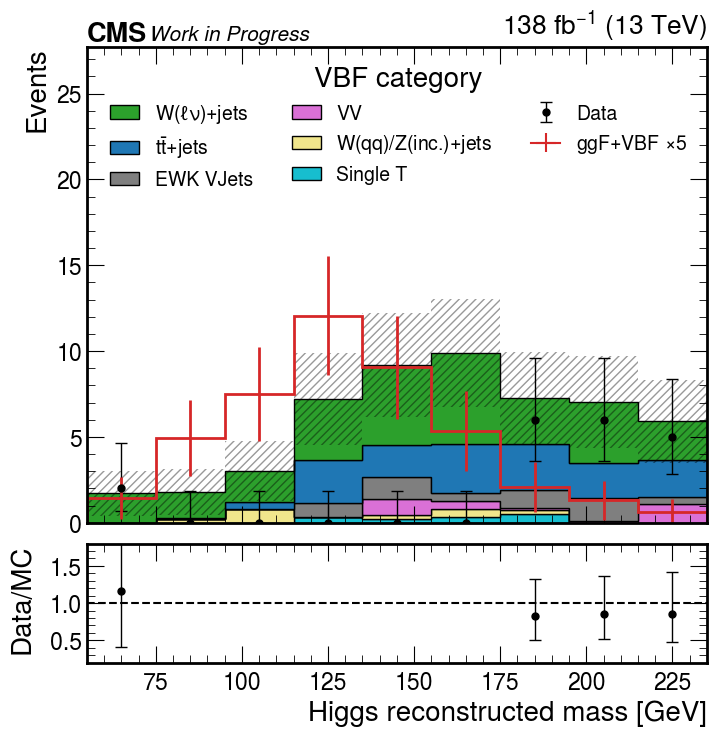

In [133]:
# region = "VBF915"

region = "VBF913"
text = "VBF category"

# region = "ggF925"
# text = "ggF category"

# region = "ggF925pt250to300"
# text = r"ggF $p_T$ $\in$ [250, 300]"

# region = "ggF925pt300to450"
# text = r"ggF $p_T$ $\in$ [300, 450]"

# region = "ggF925pt450toInf"
# text = r"ggF $p_T$ $\in$ [450, Inf]"

# region = "TopCR"
# text = "Top control region"

# region = "WJetsCR91"
# text = "WJets control region"


plt.rcParams.update({"font.size": 20})
add_data = True

# if region.startswith("SR"):
add_soverb=True
blind_region=[90,160]
if "VBF" in region:
    mult=5
else:
    mult=10
# else:
#     add_soverb=True
#     blind_region=None
#     blind_region=[90,160]
#     mult=1

if "CR" in region:
    blind_region = False
    mult=1

years = ["2018", "2017", "2016", "2016APV"]
channels = ["ele", "mu"]

from utilsCombine import plot_hists
from utilsCombine2 import plot_hists

plot_hists(h[{"Systematic": "nominal", "Region": region}], years, channels,
            add_data=add_data,
            logy=False,
            add_soverb=add_soverb,
            only_sig=False,
            mult=mult,
            outpath=f"/Users/fmokhtar/Desktop/AN_2024/combine/",
           save_as=region,
#             text_="Signal Regions",
#            text_=region,
#            text_="Signal region \n (VBF category)",
#            text_="Signal region \n"  + r"(ggF $p_T$ $\in$ [250, 300])",
           text_=text,
#            text_=r"Signal region \n (ggF $p_T$ $\in$ [450, inf])",           

            blind_region=blind_region,
           remove_samples=["WH", "ZH", "ttH"],
          )

# Post-fit stacked plots

In [16]:
samples_dict = {
    "data": "Data",
    "VBF": "VBF",
    "WH": "WH",
    "ZH": "ZH",
    "diboson": "Diboson",
    "ewkvjets": "EWKvjets",
    "ggF": "ggF",
    "singletop": "SingleTop",
    "qcd": "QCD",
    "ttH": "ttH",
    "ttbar": "TTbar",
    "wjets": "WJetsLNu",
    
    "wzqq": "WZQQ",    
    "zjets": "DYJets",      
    "vjets": "WZQQorDYJets"
    
}

region_dict = {
    "SR1": "VBF category",
    "SR2": r"ggF $p_T$ $\in$ [250, 300]",
    "SR3": r"ggF $p_T$ $\in$ [300, 450]",
    "SR4": r"ggF $p_T$ $\in$ [450, Inf]",
    
    "CR1": "Top control region",
    "CR2": "WJets control region",
}

region_dict_h = {
    "SR1": "VBF97",
    "SR2": "ggF975pt250to300",
    "SR3": "ggF975pt300to450",
    "SR4": "ggF975pt450toInf",
    
    "CR1": "TopCR",
    "CR2": "WJetsCR",
}

# f = uproot.open("/Users/fmokhtar/Downloads/v8/blinding all regions/fitDiagnosticsBlinded.root")
# f = uproot.open("/Users/fmokhtar/Downloads/v8/blinding only SR/fitDiagnosticsBlinded.root")
# add_back_MC = "v8"

# f = uproot.open("/Users/fmokhtar/Downloads/v8/asimov/fitDiagnosticsAsimov.root")
add_back_MC=False


# f = uproot.open("/Users/fmokhtar/Downloads/v8/asimov/fitDiagnosticsAsimov.root")
f = uproot.open("/Users/fmokhtar/Downloads/v4/fitDiagnosticsAsimov.root")

In [30]:
massbinwidth = {
    "SR1": 20,
    "SR2": 20,
    "SR3": 20,
    "SR4": 20,
    "CR1": 20,
    "CR2": 20,
}

def plot_(key="shapes_fit_s", region="SR1", mult=1, add_back_MC=None):
    
    """
    add_back_MC: if None then won't add back MC. if True must be e.g. "v8" to get the nominal values.
    """

    if add_back_MC:
        # get lumi
        import pickle as pkl
        with open(f"../combine/templates/{add_back_MC}/hists_templates_Run2.pkl", "rb") as filename:    
            h = pkl.load(filename)

    ######################
    nbins = len(list(range(55, 255, massbinwidth[region])))-1
    samples = [samples_dict[sample[:-2]] for sample in f[f"{key}/{region}"].keys() if "total" not in sample]

    hf = hist2.Hist(
        hist2.axis.StrCategory(samples, name="Sample", growth=True),    
        hist2.axis.Regular(nbins, 55, 235, name="var", label=r"Higgs reconstructed mass [GeV]")
    )


    for sample in  f[f"{key}/{region}"].keys():
        if "total" in sample:
            continue

        if "data" in sample:    
            X = f[f"{key}/{region}"][sample].values()[1]*massbinwidth[region]
        else:
            X = f[f"{key}/{region}"][sample].values()*massbinwidth[region]
 
            if add_back_MC:
                # add MC back in the blinded region
                X[2:6] = h[region_dict_h[region]][{"Sample": samples_dict[sample[:-2]], "Systematic": "nominal"}].values()[2:6]

        hf[{"Sample": samples_dict[sample[:-2]]}] = X

    plt.rcParams.update({"font.size": 20})
    add_data = True   # assumes it's Asimov

    years = ["2018", "2017", "2016", "2016APV"]
    channels = ["ele", "mu"]

    from utilsCombine4 import plot_hists

    plot_hists(hf, years, channels,
                add_data=add_data,
                logy=False,
                add_soverb=False,
                only_sig=False,
                mult=mult,
                outpath=f"/Users/fmokhtar/Desktop/AN_2024/combine/",
               save_as=f"{key}_{region}",
               text_=region_dict[region],
               blind_region=False,
               remove_samples=["ttH", "WH", "ZH"]
              )

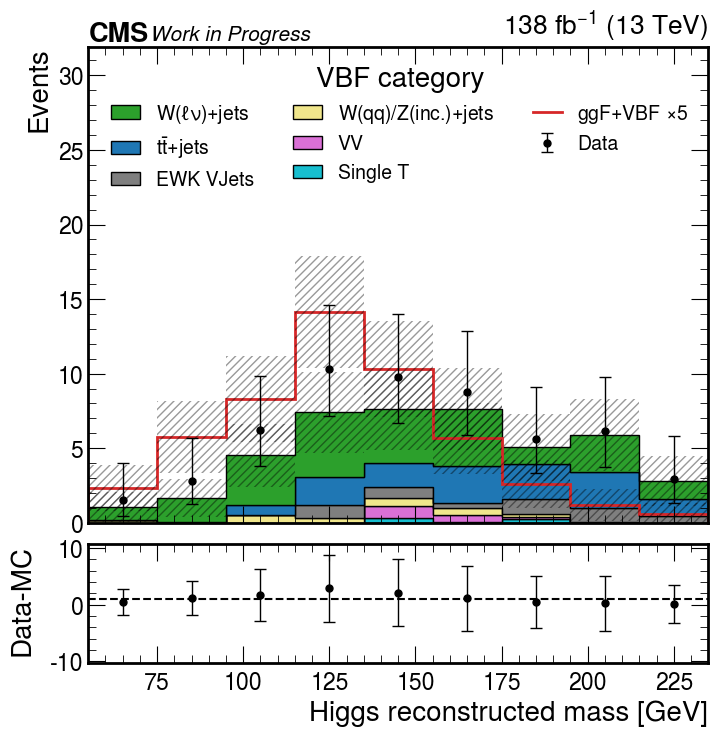

In [36]:
plot_(key="shapes_fit_s", region="SR1", mult=5, add_back_MC=add_back_MC)

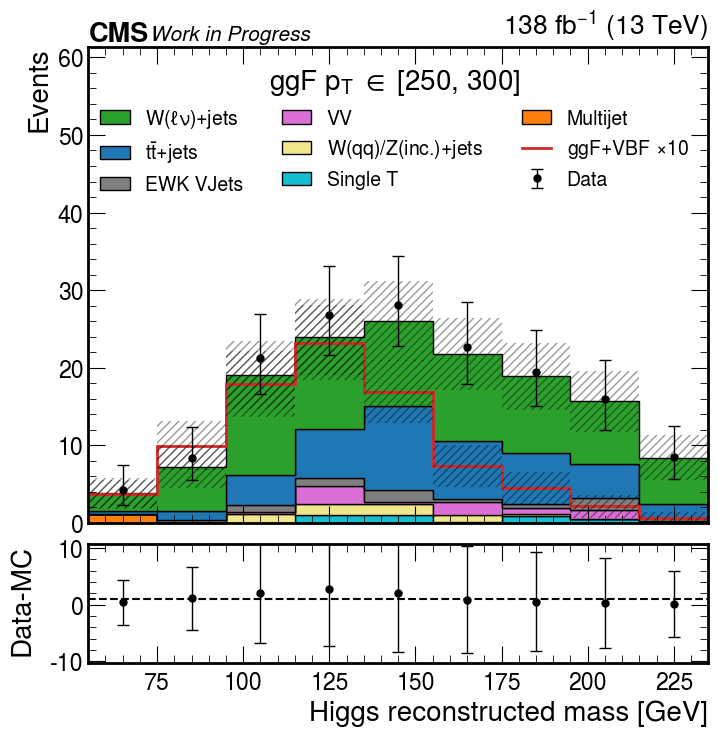

In [35]:
plot_(key="shapes_fit_s", region="SR2", mult=10, add_back_MC=add_back_MC)

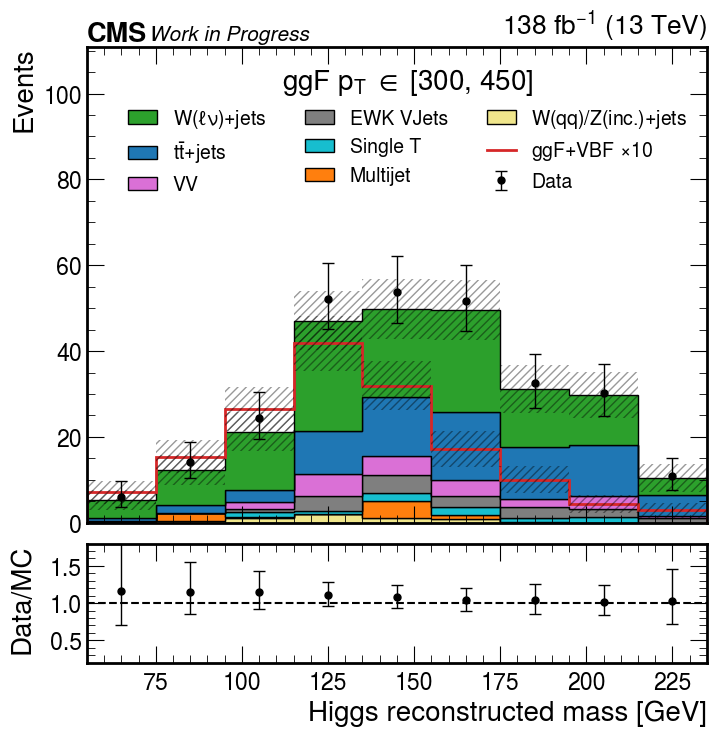

In [25]:
plot_(key="shapes_fit_s", region="SR3", mult=10, add_back_MC=add_back_MC)

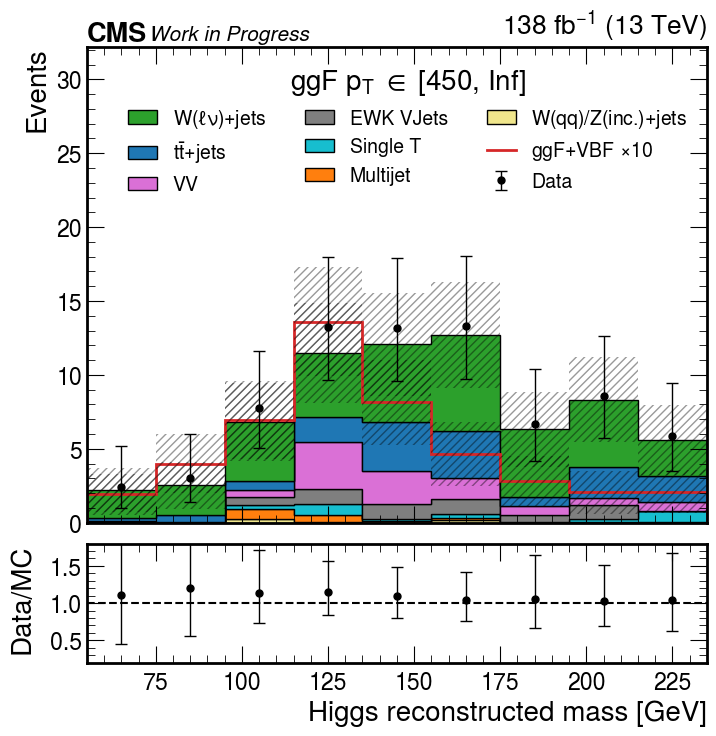

In [26]:
plot_(key="shapes_fit_s", region="SR4", mult=10, add_back_MC=add_back_MC)

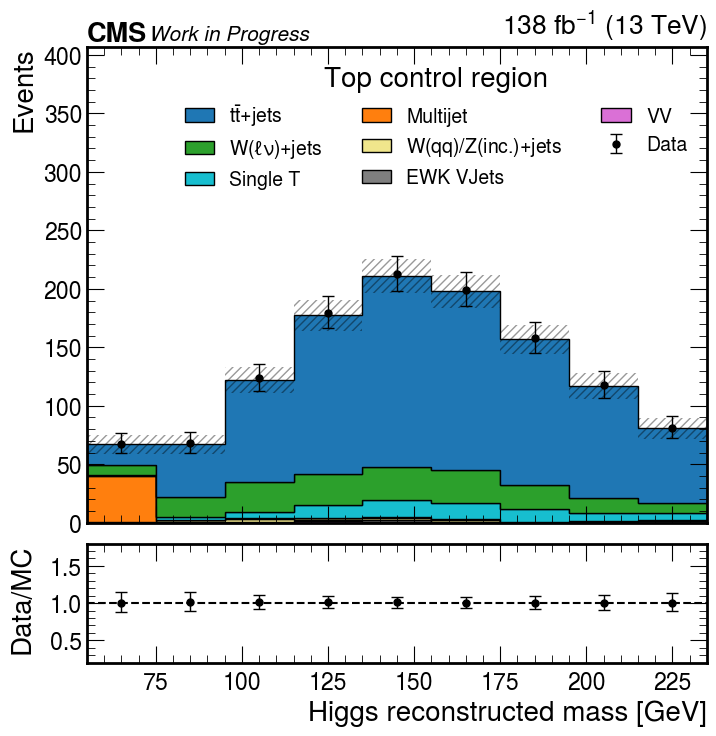

In [27]:
plot_(key="shapes_fit_s", region="CR1", mult=1)

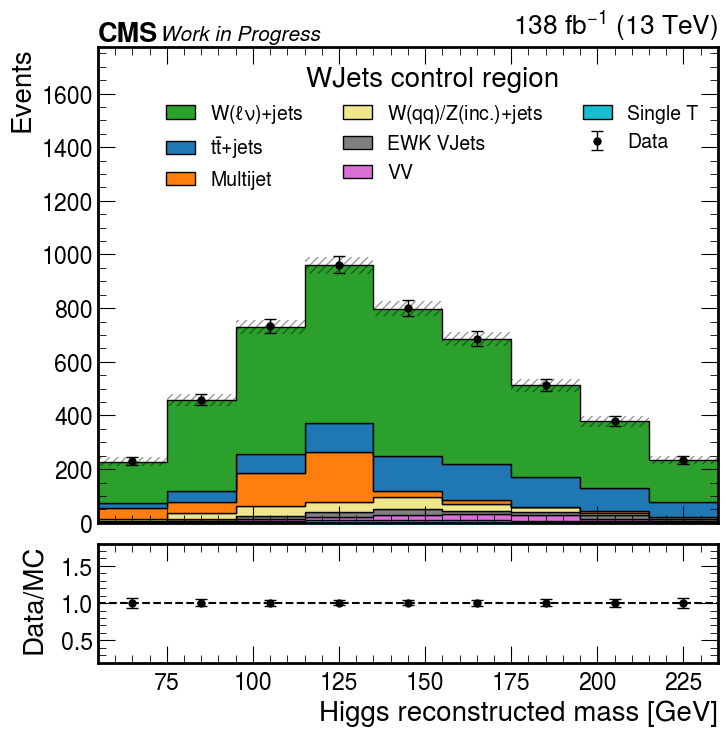

In [28]:
plot_(key="shapes_fit_s", region="CR2", mult=1)

In [29]:
f[f"shapes_prefit/SR2"]["wjets"].values()*20

array([ 2.3676536,  5.6572156, 12.80648  , 11.880279 , 10.951158 ,
       11.199667 ,  9.851049 ,  8.078206 ,  5.984292 ], dtype=float32)

In [324]:
f[f"shapes_fit_s/SR2"]["wjets"].values()*20

array([7.1978683e+00, 1.6718464e+01, 1.1378644e-06, 1.1378644e-06,
       1.1378644e-06, 1.1378644e-06, 1.4981668e+01, 1.2238329e+01,
       5.7568893e+00], dtype=float32)

In [454]:
f.keys()

['shapes_prefit;1',
 'shapes_prefit/CR1;1',
 'shapes_prefit/CR1/data;1',
 'shapes_prefit/CR1/VBF;1',
 'shapes_prefit/CR1/WH;1',
 'shapes_prefit/CR1/ZH;1',
 'shapes_prefit/CR1/diboson;1',
 'shapes_prefit/CR1/ewkvjets;1',
 'shapes_prefit/CR1/ggF;1',
 'shapes_prefit/CR1/qcd;1',
 'shapes_prefit/CR1/singletop;1',
 'shapes_prefit/CR1/ttH;1',
 'shapes_prefit/CR1/ttbar;1',
 'shapes_prefit/CR1/wjets;1',
 'shapes_prefit/CR1/wzqq;1',
 'shapes_prefit/CR1/zjets;1',
 'shapes_prefit/CR1/total;1',
 'shapes_prefit/CR1/total_signal;1',
 'shapes_prefit/CR1/total_background;1',
 'shapes_prefit/CR1/total_covar;1',
 'shapes_prefit/CR2;1',
 'shapes_prefit/CR2/data;1',
 'shapes_prefit/CR2/VBF;1',
 'shapes_prefit/CR2/WH;1',
 'shapes_prefit/CR2/ZH;1',
 'shapes_prefit/CR2/diboson;1',
 'shapes_prefit/CR2/ewkvjets;1',
 'shapes_prefit/CR2/ggF;1',
 'shapes_prefit/CR2/qcd;1',
 'shapes_prefit/CR2/singletop;1',
 'shapes_prefit/CR2/ttH;1',
 'shapes_prefit/CR2/ttbar;1',
 'shapes_prefit/CR2/wjets;1',
 'shapes_prefit/CR2/w

In [253]:
from hist import Hist

h = (Hist.new.Reg(5, 0, 5, name="X", label="x [units]").Double())
print(h)
h[0:5] = [2., 0., 0., 0., 0.] # Setting the content
print(h) # THe value 2 is not in there anymore as the whole array content has been set

              ┌──────────────────────────────────────────────────────────────┐
[-inf,   0) 0 │                                                              │
[   0,   1) 0 │                                                              │
[   1,   2) 0 │                                                              │
[   2,   3) 0 │                                                              │
[   3,   4) 0 │                                                              │
[   4,   5) 0 │                                                              │
[   5, inf) 0 │                                                              │
              └──────────────────────────────────────────────────────────────┘
              ┌──────────────────────────────────────────────────────────────┐
[-inf,   0) 0 │                                                              │
[   0,   1) 2 │█████████████████████████████████████████████████████████████ │
[   1,   2) 0 │                                     

In [228]:
h

Hist(Regular(5, 0, 5, name='X', label='x [units]'), storage=Double()) # Sum: 2.0

In [93]:
hists2

Hist(
  StrCategory(['data', 'VBF', 'WH', 'ZH', 'diboson', 'ewkvjets', 'ggF', 'singletop', 'ttH', 'ttbar', 'wjets', 'wzqq', 'zjets'], growth=True, name='Sample'),
  Variable([50, 70, 90, 110, 130, 150, 170, 190, 210, 230], name='var', label='Higgs reconstructed mass (Option 1) [GeV]'),
  storage=Double()) # Sum: 0.0 (109.0 with flow)

In [97]:
X

array([3.5970001e-07, 2.8934646e-01, 1.1281960e+00, 2.3665266e+00,
       2.1397738e+00, 3.7559786e+00, 2.8726485e+00, 2.8236213e+00,
       2.6089082e+00], dtype=float32)

In [99]:
len(list(range(50, 240, massbin)))

10

In [80]:
hists2[{"Sample": "ttbar"}].values()

array([0., 0., 0., 0., 0., 0., 0., 0.])

In [68]:
[f"{key}/{region}"]["ttbar"].values()

<>:1: SyntaxWarning: list indices must be integers or slices, not str; perhaps you missed a comma?
<>:1: SyntaxWarning: list indices must be integers or slices, not str; perhaps you missed a comma?
/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_95386/2199467129.py:1: SyntaxWarning: list indices must be integers or slices, not str; perhaps you missed a comma?
  [f"{key}/{region}"]["ttbar"].values()
/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_95386/2199467129.py:1: SyntaxWarning: list indices must be integers or slices, not str; perhaps you missed a comma?
  [f"{key}/{region}"]["ttbar"].values()
/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_95386/2199467129.py:1: SyntaxWarning: list indices must be integers or slices, not str; perhaps you missed a comma?
  [f"{key}/{region}"]["ttbar"].values()


TypeError: list indices must be integers or slices, not str

In [56]:
hists["rec_higgs_m"][{"Sample": }]

Hist(
  StrCategory(['VBF', 'WJetsLNu', 'EWKvjets', 'Diboson', 'WH', 'TTbar', 'SingleTop', 'ggF', 'DYJets', 'QCD', 'Data', 'WZQQ', 'ttH', 'ZH'], growth=True, name='Sample'),
  Variable([50, 70, 90, 110, 130, 150, 170, 190, 210, 230], name='mass_observable', label='Higgs reconstructed mass [GeV]'),
  storage=Weight()) # Sum: WeightedSum(value=162.112, variance=92.5995) (WeightedSum(value=185.818, variance=108.932) with flow)

# Just before old

In [47]:
legend_lab = {
    "shapes_prefit": "Prefit",
    "shapes_fit_b": "B-Fit",
    "shapes_fit_s": "S+B-Fit"
}
color_by_sample = {
    "total_background": "tab:blue",
    "total_signal": "tab:red",
#     "ggF": "pink",
#     "VH": "tab:brown",
#     "VBF": "tab:gray",
#     "ttH": "tab:olive",
#     "DYJets": "tab:purple",
    "qcd": "tab:purple",
    "Diboson": "orchid",
#     "wjets": "tab:purple",
    "wjets": "tab:orange",    
    "ttbar": "tab:blue",
    "WZQQ": "salmon",
#     "SingleTop": "tab:cyan",
#     "CMS_HWW_boosted_qcd_datadriven": "tab:orange",
#     "CMS_HWW_boosted_wjets_datadriven": "tab:orange",
    "wjetsqcd": "tab:orange",
}


samples = [
    "data",
    "total_background",
    "total_signal",        
#     "CMS_HWW_boosted_qcd_datadriven",
#     "CMS_HWW_boosted_wjets_datadriven",    
#     "wjets",    
#     "wjetsqcd",        
#     "ttbar",
#     "qcd",
]

def blindBins(X):
    X[2:6] = 0
    return X

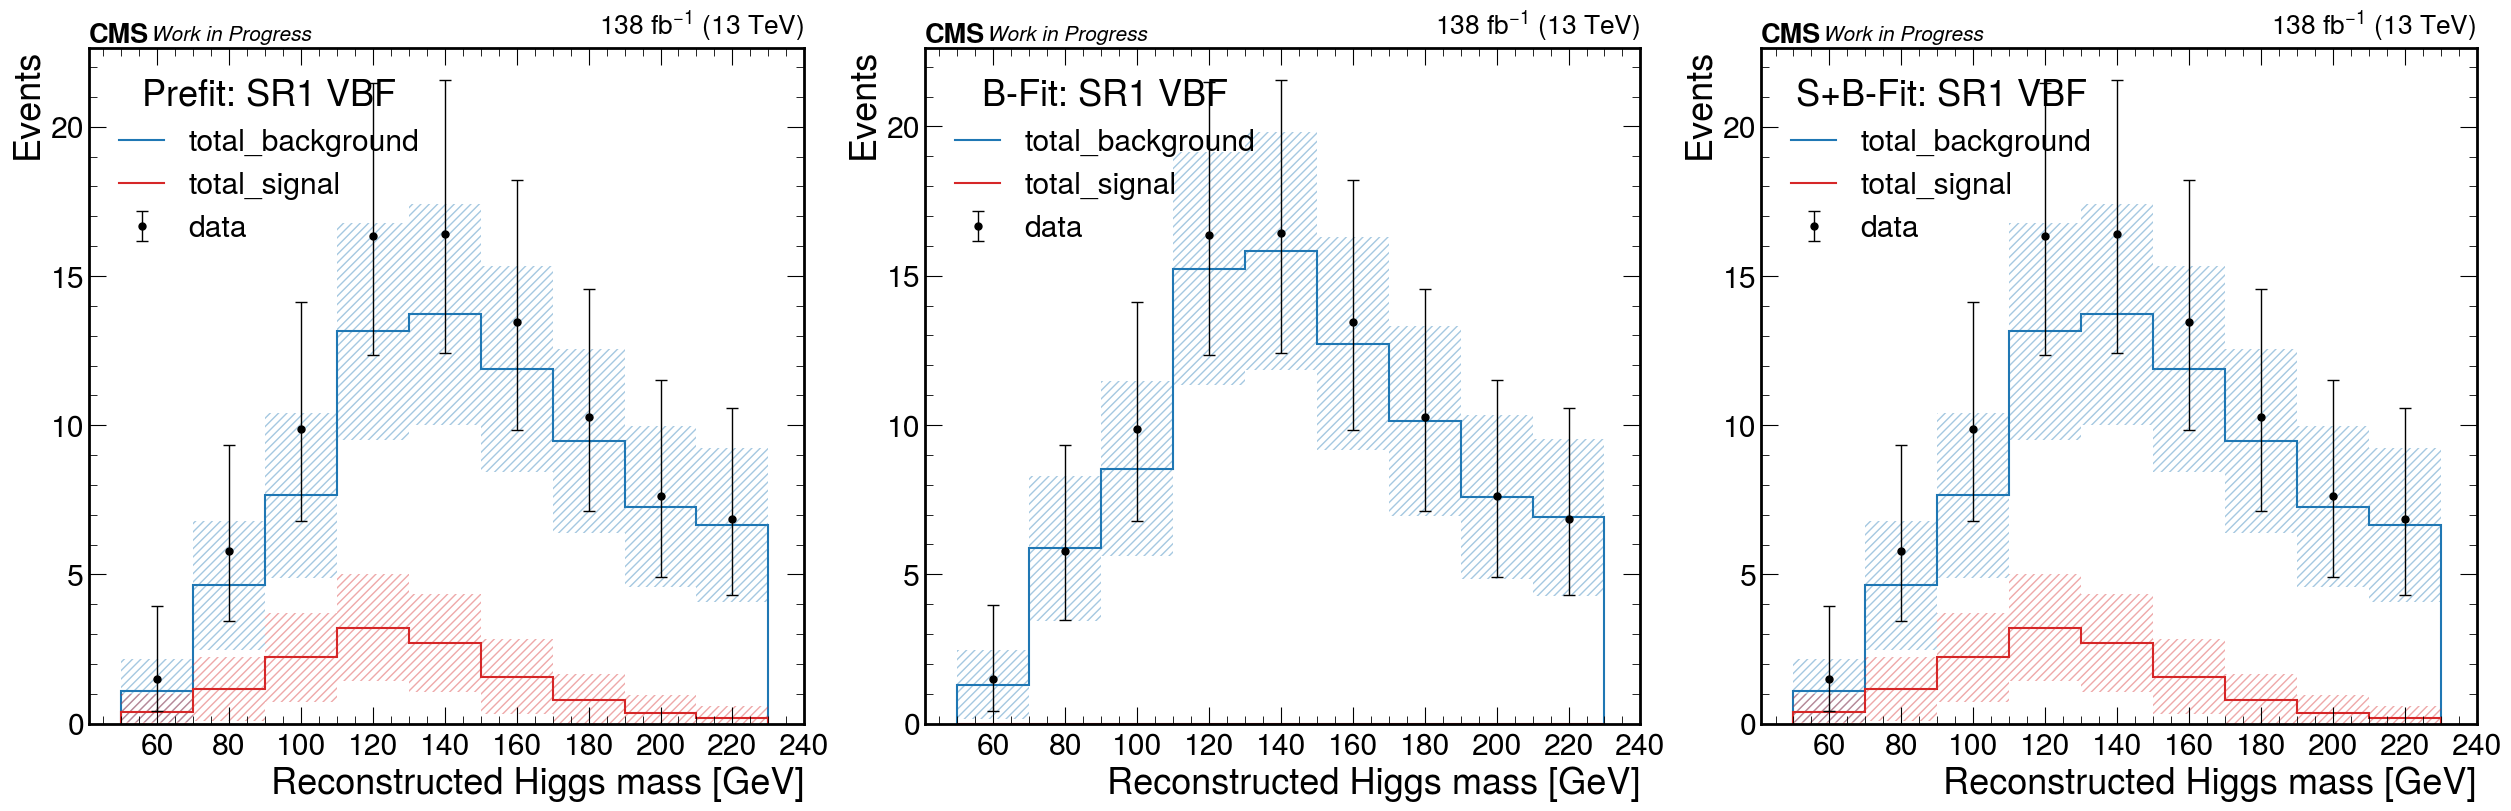

In [49]:
region_label_dict = {
    "SR1": r"$\mathrm{SR1} \ \mathrm{VBF}$",
    "SR2": r"$\mathrm{SR1} \ \mathrm{ggF} \ p_T \in [250, 300]$",    
    "SR3": r"$\mathrm{SR1} \ \mathrm{ggF} \ p_T \in [300, 450]$",
    "SR4": r"$\mathrm{SR1} \ \mathrm{ggF} \ p_T \in [450, \mathrm{Inf}]$",
    "CR1": "Wjets CR",
    "CR2": "Top CR",
}

# f = uproot.open("fitDiagnosticsAsimov.root")
# f = uproot.open("fitDiagnosticsAsimovRate.root")

f = uproot.open("/Users/fmokhtar/Downloads/fitDiagnosticsAsimov.root")

binwidth = 20

region = "SR1"
# region = "CR"


# do = [f"shapes_prefit", f"shapes_fit_b"]
# do = [f"shapes_prefit", f"shapes_fit_s"]
do = [f"shapes_prefit", f"shapes_fit_b", "shapes_fit_s"]

errps = {
        "hatch": "////",
        "facecolor": "none",
        "lw": 0,
        "color": "tab:grey",
#         "edgecolor": (0, 0, 0, 0.5),
        "linewidth": 0,
        "alpha": 0.4,
}


if len(do) == 2:
    fig, axs = plt.subplots(1, 2, figsize=(17,8), constrained_layout=True)    
else:
    fig, axs = plt.subplots(1, 3, figsize=(25,8), constrained_layout=True)

for i, key in enumerate(do):

    for sample in samples:
        
#         if (sample == "total_signal") and (key=="shapes_fit_b"):
#             continue
        
#         if "qcd" in sample:
#             if region == "passBlinded2":
#                 sample += f"_pass"
#             else:
#                 sample += f"_{region}"
            
        if sample == "data":
            
            X = f[f"{key}/{region}"]["data"].values()[1]*binwidth
            
#             if "CR" not in region:
#                 X = blindBins(X)
            
            hep.histplot(
                X,
                bins=list(range(50, 240, binwidth)),
                ax=axs[i],
                label=sample,
                histtype="errorbar",
                color="k",
                capsize=4,    
#                 yerr="w2"
            )   

        else:
            
            if sample == "qcd" and "CR" not in region:
                continue
                
#             elif sample == "wjets":
#                 lab = "WJets+QCD (MC)"
#                 try:
#                     X = f[f"{key}/{region}"]["wjets"].values()*binwidth
#                     if "qcd;1" in f[f"{key}/{region}"].keys():
#                         X += f[f"{which_fit}/{region}"]["qcd"].values()*binwidth
#                 except KeyError:
#                     print(f"can't find {sample} sample in {key}/{region}")
#                     continue                    
            
#             else:
            try:
                X = f[f"{key}/{region}"][sample].values()*binwidth
            except KeyError:
                print(f"can't find {sample} sample in {key}/{region}")
                continue  
            lab = sample

            hep.histplot(             
                X,
                bins=list(range(50, 240, binwidth)),
                ax=axs[i],
                histtype="step",
                label=lab,
                color=color_by_sample[sample],
                flow="none",                
            )   
            errps["color"] = color_by_sample[sample]
            axs[i].stairs(
                values= X + np.sqrt(X),
                baseline= X - np.sqrt(X),
                edges=list(range(50, 240, binwidth)),
                **errps,
#                 label="Stat. unc.",
            )
            

    axs[i].legend(title=f"{legend_lab[key]}: {region_label_dict[region]}", loc="upper left")
    
    axs[i].set_ylabel(f"Events")
    axs[i].set_xlabel(f"Reconstructed Higgs mass [GeV]")
#     if region =="SR1":
#         axs[i].set_ylim(0, 9)
#     elif region =="SR2":
#         axs[i].set_ylim(0, 80)
#     elif region == "SR3":
#         axs[i].set_ylim(0, 19)
#     elif region == "SR4":
#         axs[i].set_ylim(0, 140)
#     elif region == "CR":
#         axs[i].set_ylim(0, 9500)
        
    axs[i].set_ylim(0)        
    
    hep.cms.lumitext("%.0f " % full_lumi + r"fb$^{-1}$ (13 TeV)", ax=axs[i], fontsize=20)
    hep.cms.text("Work in Progress", ax=axs[i], fontsize=15)

    axs[i].set_xticks(np.array(list(range(50, 240, 20))) + 10)
    
plt.savefig(f"/Users/fmokhtar/Desktop/AN/combine.pdf")        

# Old

can't find CMS_HWW_boosted_qcd_datadriven sample in shapes_prefit/SR2
can't find CMS_HWW_boosted_wjets_datadriven sample in shapes_prefit/SR2
can't find wjetsqcd sample in shapes_prefit/SR2
can't find CMS_HWW_boosted_qcd_datadriven sample in shapes_fit_b/SR2
can't find CMS_HWW_boosted_wjets_datadriven sample in shapes_fit_b/SR2
can't find wjetsqcd sample in shapes_fit_b/SR2
can't find CMS_HWW_boosted_qcd_datadriven sample in shapes_fit_s/SR2
can't find CMS_HWW_boosted_wjets_datadriven sample in shapes_fit_s/SR2
can't find wjetsqcd sample in shapes_fit_s/SR2


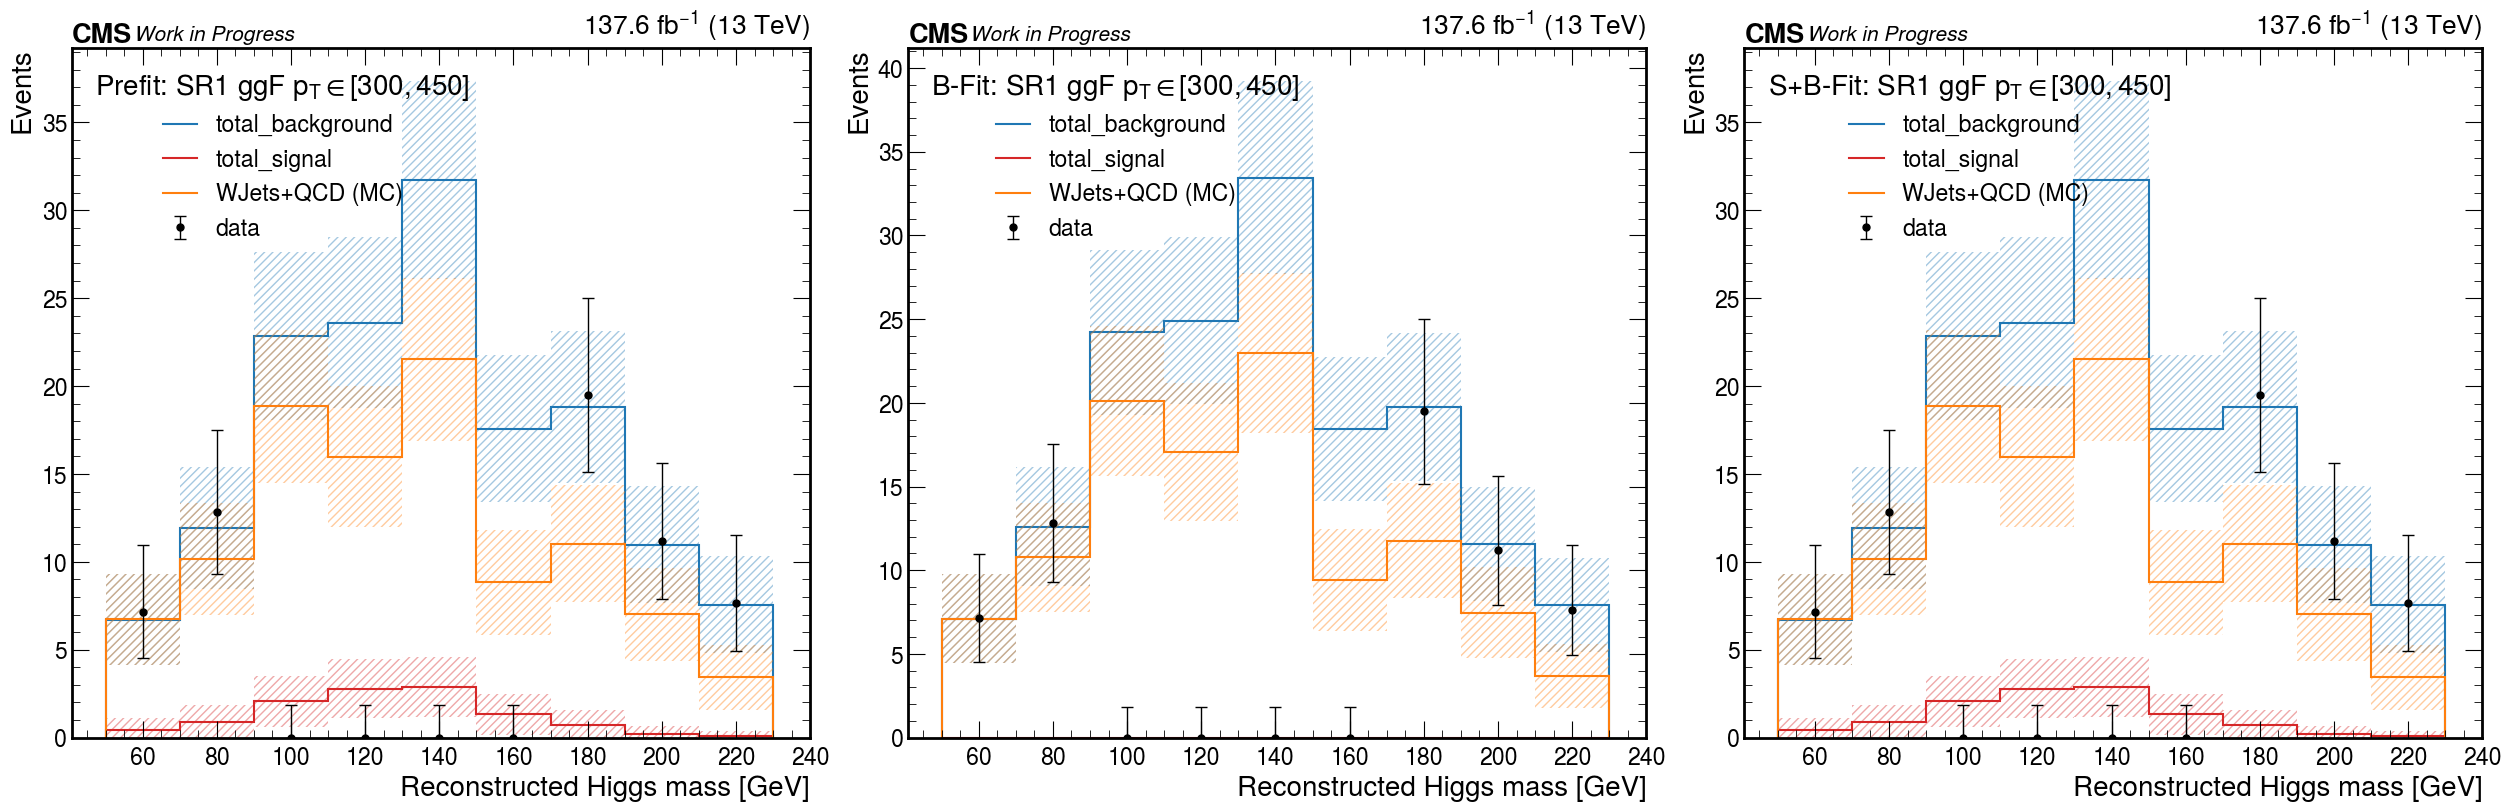

In [189]:
region_label_dict = {
    "SR1": r"$\mathrm{SR1} \ \mathrm{VBF}$",
    "SR2": r"$\mathrm{SR1} \ \mathrm{ggF} \ p_T \in [300, 450]$",
    "SR3": r"$\mathrm{SR1} \ \mathrm{ggF} \ p_T \in [450, \mathrm{Inf}]$",
    "SR4": r"$\mathrm{SR2}$",
    "CR": "Wjets CR",    
    "CR1": "Wjets CR",
    "CR2": "Wjets CR",
    "CR3": "Wjets CR",
    "CR4": "Wjets CR",   
}
f = uproot.open("fitDiagnosticsTestMC.root")
f = uproot.open("fitDiagnosticsTestRhalphabet.root")
f = uproot.open("fitDiagnosticsTest.root")
f = uproot.open("fitDiagnosticsAsimov.root")

binwidth = 20

region = "SR2"
# region = "CR"

if region=="TopCR":
    samples = samplestop
else:
    samples = samplesSR


# do = [f"shapes_prefit", f"shapes_fit_b"]
# do = [f"shapes_prefit", f"shapes_fit_s"]
do = [f"shapes_prefit", f"shapes_fit_b", "shapes_fit_s"]

errps = {
        "hatch": "////",
        "facecolor": "none",
        "lw": 0,
        "color": "tab:grey",
#         "edgecolor": (0, 0, 0, 0.5),
        "linewidth": 0,
        "alpha": 0.4,
}


if len(do) == 2:
    fig, axs = plt.subplots(1, 2, figsize=(17,8), constrained_layout=True)    
else:
    fig, axs = plt.subplots(1, 3, figsize=(25,8), constrained_layout=True)

for i, key in enumerate(do):

    for sample in samples:
        
#         if (sample == "total_signal") and (key=="shapes_fit_b"):
#             continue
        
#         if "qcd" in sample:
#             if region == "passBlinded2":
#                 sample += f"_pass"
#             else:
#                 sample += f"_{region}"
            
        if sample == "data":
            
            X = f[f"{key}/{region}"]["data"].values()[1]*binwidth
            
            if "CR" not in region:
                X = blindBins(X)
            
            hep.histplot(
                X,
                bins=list(range(50, 240, binwidth)),
                ax=axs[i],
                label=sample,
                histtype="errorbar",
                color="k",
                capsize=4,    
#                 yerr="w2"
            )   

        else:
            
            
            if (sample == "CMS_HWW_boosted_qcd_datadriven") or (sample == "CMS_HWW_boosted_wjets_datadriven"):
                lab = "WJets+QCD (data-driven)"
                try:
                    X = f[f"{key}/{region}"][sample].values()*binwidth
                except KeyError:
                    print(f"can't find {sample} sample in {key}/{region}")
                    continue

            elif sample == "qcd":
                continue
                
            elif sample == "wjets":
                lab = "WJets+QCD (MC)"
                try:
                    X = f[f"{key}/{region}"]["wjets"].values()*binwidth
                    if "qcd;1" in f[f"{key}/{region}"].keys():
                        X += f[f"{which_fit}/{region}"]["qcd"].values()*binwidth
                except KeyError:
                    print(f"can't find {sample} sample in {key}/{region}")
                    continue                    
            
            else:
                try:
                    X = f[f"{key}/{region}"][sample].values()*binwidth
                except KeyError:
                    print(f"can't find {sample} sample in {key}/{region}")
                    continue  
                lab = sample

            hep.histplot(             
                X,
                bins=list(range(50, 240, binwidth)),
                ax=axs[i],
                histtype="step",
                label=lab,
                color=color_by_sample[sample],
                flow="none",                
            )   
            errps["color"] = color_by_sample[sample]
            axs[i].stairs(
                values= X + np.sqrt(X),
                baseline= X - np.sqrt(X),
                edges=list(range(50, 240, binwidth)),
                **errps,
#                 label="Stat. unc.",
            )
            

    axs[i].legend(title=f"{legend_lab[key]}: {region_label_dict[region]}", loc="upper left")
    
    axs[i].set_ylabel(f"Events")
    axs[i].set_xlabel(f"Reconstructed Higgs mass [GeV]")
#     if region =="SR1":
#         axs[i].set_ylim(0, 9)
#     elif region =="SR2":
#         axs[i].set_ylim(0, 80)
#     elif region == "SR3":
#         axs[i].set_ylim(0, 19)
#     elif region == "SR4":
#         axs[i].set_ylim(0, 140)
#     elif region == "CR":
#         axs[i].set_ylim(0, 9500)
        
    axs[i].set_ylim(0)        
    
    hep.cms.lumitext("%.1f " % full_lumi + r"fb$^{-1}$ (13 TeV)", ax=axs[i], fontsize=20)
    hep.cms.text("Work in Progress", ax=axs[i], fontsize=15)

    axs[i].set_xticks(np.array(list(range(50, 240, 20))) + 10)
    
plt.savefig(f"/Users/fmokhtar/Desktop/AN/combine.pdf")        

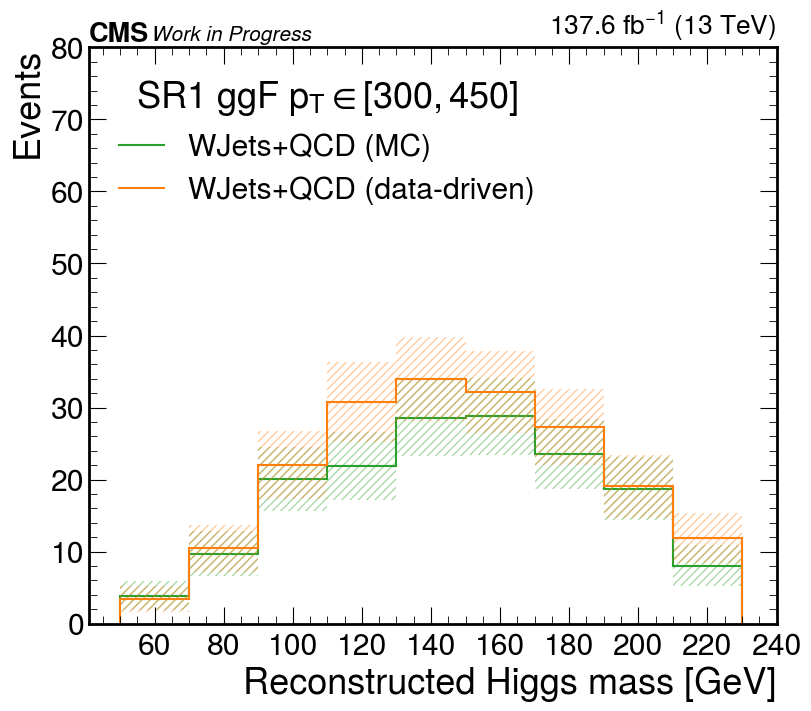

In [102]:
region_label_dict = {
    "SR1": r"$\mathrm{SR1} \ \mathrm{VBF}$",
    "SR2": r"$\mathrm{SR1} \ \mathrm{ggF} \ p_T \in [300, 450]$",
    "SR3": r"$\mathrm{SR1} \ \mathrm{ggF} \ p_T \in [450, \mathrm{Inf}]$",
    "SR4": r"$\mathrm{SR2}$",
    "CR": "Wjets CR",    
    "CR1": "Wjets CR",
    "CR2": "Wjets CR",
    "CR3": "Wjets CR",
    "CR4": "Wjets CR",   
}
errps = {
        "hatch": "////",
        "facecolor": "none",
        "lw": 0,
        "color": "tab:grey",
#         "edgecolor": (0, 0, 0, 0.5),
        "linewidth": 0,
        "alpha": 0.4,
}


binwidth = 20
region = "SR2"
# region = "CR"
which_fit = "shapes_fit_b"

fig, ax = plt.subplots(figsize=(8,7), constrained_layout=True)

# plot MC
f = uproot.open("fitDiagnosticsTestMC.root")
X = f[f"{which_fit}/{region}"]["wjets"].values()*binwidth
if "qcd;1" in f[f"{which_fit}/{region}"].keys():
    X += f[f"{which_fit}/{region}"]["qcd"].values()*binwidth
lab = "WJets+QCD (MC)"
hep.histplot(             
    X,
    bins=list(range(50, 240, binwidth)),
    ax=ax,
    histtype="step",
    label=lab,
    color="tab:green",
    flow="none",                
)   
errps["color"] = "tab:green"
ax.stairs(
    values= X + np.sqrt(X),
    baseline= X - np.sqrt(X),
    edges=list(range(50, 240, binwidth)),
    **errps,
#                 label="Stat. unc.",
)

# plot rhalphabet
f = uproot.open("fitDiagnosticsTest.root")
X = f[f"{which_fit}/{region}"]["CMS_HWW_boosted_wjets_datadriven"].values()*binwidth
lab = "WJets+QCD (data-driven)"
hep.histplot(             
    X,
    bins=list(range(50, 240, binwidth)),
    ax=ax,
    histtype="step",
    label=lab,
    color=color_by_sample[sample],
    flow="none",                
)   
errps["color"] = color_by_sample[sample]
ax.stairs(
    values= X + np.sqrt(X),
    baseline= X - np.sqrt(X),
    edges=list(range(50, 240, binwidth)),
    **errps,
#                 label="Stat. unc.",
)

ax.legend(title=f"{region_label_dict[region]}", loc="upper left")

ax.set_ylabel(f"Events")
ax.set_xlabel(f"Reconstructed Higgs mass [GeV]")

if region =="SR1":
    ax.set_ylim(0, 9)
elif region =="SR2":
    ax.set_ylim(0, 80)
elif region == "SR3":
    ax.set_ylim(0, 19)
elif region == "SR4":
    ax.set_ylim(0, 140)
elif region == "CR":
    ax.set_ylim(0, 9500)    

hep.cms.lumitext("%.1f " % full_lumi + r"fb$^{-1}$ (13 TeV)", ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)

ax.set_xticks(np.array(list(range(50, 240, 20))) + 10);
    
plt.savefig(f"/Users/fmokhtar/Desktop/AN/combine.pdf")        

KeyInFileError: not found: 'wjets' (with any cycle number)

    Available keys: 'zjets;1', 'ttH;1', 'data;1', 'VH;1', 'VBF;1', 'ggF;1', 'ttbar;1', 'total;1', 'singletop;1', 'total_signal;1', 'total_covar;1', 'total_background;1', 'CMS_HWW_boosted_qcd_datadriven;1'

in file fitDiagnosticsTest.root

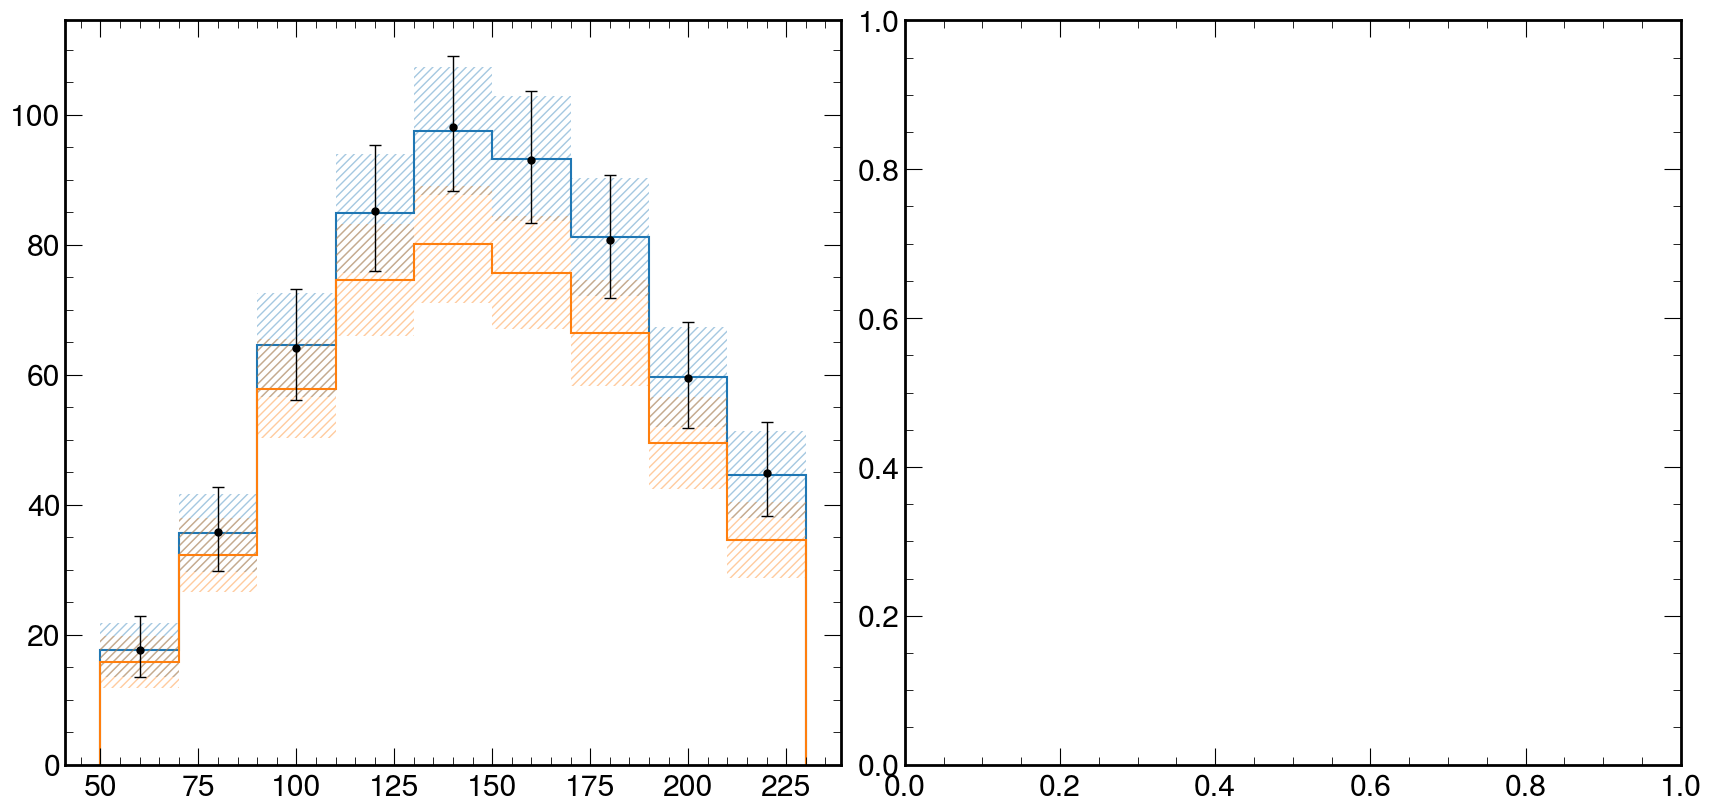

In [615]:
region_label_dict = {
    "SR1": r"$\mathrm{SR1} \ \mathrm{VBF}$",
    "SR2": r"$\mathrm{SR1} \ \mathrm{ggF} \ p_T \in [300, 450]$",
    "SR3": r"$\mathrm{SR1} \ \mathrm{ggF} \ p_T \in [450, \mathrm{Inf}]$",
    "SR4": r"$\mathrm{SR2}$",
    "CR": "Wjets CR",    
    "CR1": "Wjets CR",
    "CR2": "Wjets CR",
    "CR3": "Wjets CR",
    "CR4": "Wjets CR",   
}


binwidth = 20

# region = "SR1VBFBlinded"
# region = "WJetsCRforSR1VBFBlinded"

# region = "SR1ggFpt300to450Blinded"
# region = "WJetsCRforSR1ggFpt300to450Blinded"

# region = "SR1ggFpt450toInfBlinded"
# region = "WJetsCRforSR1ggFpt450toInfBlinded"

# region = "SR2"
# region = "WJetsCRforSR2"

region = "SR4"
# region = "CR"

if region=="TopCR":
    samples = samplestop
else:
    samples = samplesSR


errps = {
        "hatch": "////",
        "facecolor": "none",
        "lw": 0,
        "color": "tab:grey",
#         "edgecolor": (0, 0, 0, 0.5),
        "linewidth": 0,
        "alpha": 0.4,
}


do = [f"shapes_fit_b", f"shapes_fit_b"]
# do = [f"shapes_prefit", f"shapes_fit_s"]
# do = [f"shapes_prefit", f"shapes_fit_b", "shapes_fit_s"]

if len(do) == 2:
    fig, axs = plt.subplots(1, 2, figsize=(17,8), constrained_layout=True)    
else:
    fig, axs = plt.subplots(1, 3, figsize=(25,8), constrained_layout=True)

for i, key in enumerate(do):

    if i==0:
        f = uproot.open("fitDiagnosticsTest.root")
    else:
        f = uproot.open("fitDiagnosticsTestBlindingAndNotFreezing.root")
        
    for sample in samples:
        
        if (sample == "total_signal") and (key=="shapes_fit_b"):
            continue
        
#         if "qcd" in sample:
#             if region == "passBlinded2":
#                 sample += f"_pass"
#             else:
#                 sample += f"_{region}"
            
        if sample == "data":
            
            hep.histplot(
                f[f"{key}/{region}"]["data"].values()[1]*binwidth,
                bins=list(range(50, 240, 20)),
                ax=axs[i],
                label=sample,
                histtype="errorbar",
                color="k",
                capsize=4,           
            )   

        else:
            if i==0:
                if sample == "qcd":
                    continue

                if sample == "wjets":        
                    X = f[f"{key}/{region}"]["wjets"].values()*binwidth
                    
                    try:
                        X += f[f"{key}/{region}"]["qcd"].values()*binwidth
                    except KeyError:
                        print(f"can't find {sample} sample in {key}/{region}")
                        

                    lab = "WJets+QCD (MC)"
                else:
                    try:
                        X = f[f"{key}/{region}"][sample].values()*binwidth
                    except KeyError:
                        print(f"can't find {sample} sample in {key}/{region}")
                        continue
                    lab=sample
                
            if i==1:
                try:
                    X = f[f"{key}/{region}"][sample].values()*binwidth
                except KeyError:
                    print(f"can't find {sample} sample in {key}/{region}")
                    continue
                    
                if "qcd" in sample:
                    lab = "WJets+QCD (data-driven)"
                else:
                    lab = sample
                
            hep.histplot(             
                X,
                bins=list(range(50, 240, 20)),
                ax=axs[i],
                histtype="step",
                label=lab,
                color=color_by_sample[sample],
                flow="none",                
            )   
            errps["color"] = color_by_sample[sample]
            axs[i].stairs(
                values= X + np.sqrt(X),
                baseline= X - np.sqrt(X),
                edges=list(range(50, 240, 20)),
                **errps,
#                 label="Stat. unc.",
            )
                        
    
    axs[i].legend(title=f"{legend_lab[key]}: {region_label_dict[region]}", loc="upper left")
    
    axs[i].set_ylabel(f"Events")
    axs[i].set_xlabel(f"Reconstructed Higgs mass [GeV]")
#     if region =="SR2":
#         axs[i].set_ylim(0, 10)
#     elif region == "SR3":
#         axs[i].set_ylim(0, 19)
#     elif region == "SR4":
#         axs[i].set_ylim(0, 140)
        
    axs[i].set_ylim(0,120)        
    
    hep.cms.lumitext("%.1f " % full_lumi + r"fb$^{-1}$ (13 TeV)", ax=axs[i], fontsize=20)
    hep.cms.text("Work in Progress", ax=axs[i], fontsize=15)

    axs[i].set_xticks(np.array(list(range(50, 240, 20))) + 10)
    
plt.savefig(f"/Users/fmokhtar/Desktop/AN/combine.pdf")        

In [212]:
a

'llaa'

In [80]:
b

'llaa'

In [247]:
f["shapes_prefit"]["SR1Blinded/total_signal"].values()*binwidth

array([1.3749026 , 2.9327927 , 0.        , 0.        , 0.        ,
       5.6135616 , 2.6943355 , 1.31041   , 0.69399726], dtype=float32)

In [248]:
f["shapes_fit_s"]["SR1Blinded/total_signal"].values()*binwidth

array([ 6.932394 , 14.77989  ,  0.       ,  0.       ,  0.       ,
       28.318079 , 13.587323 ,  6.60555  ,  3.4993017], dtype=float32)

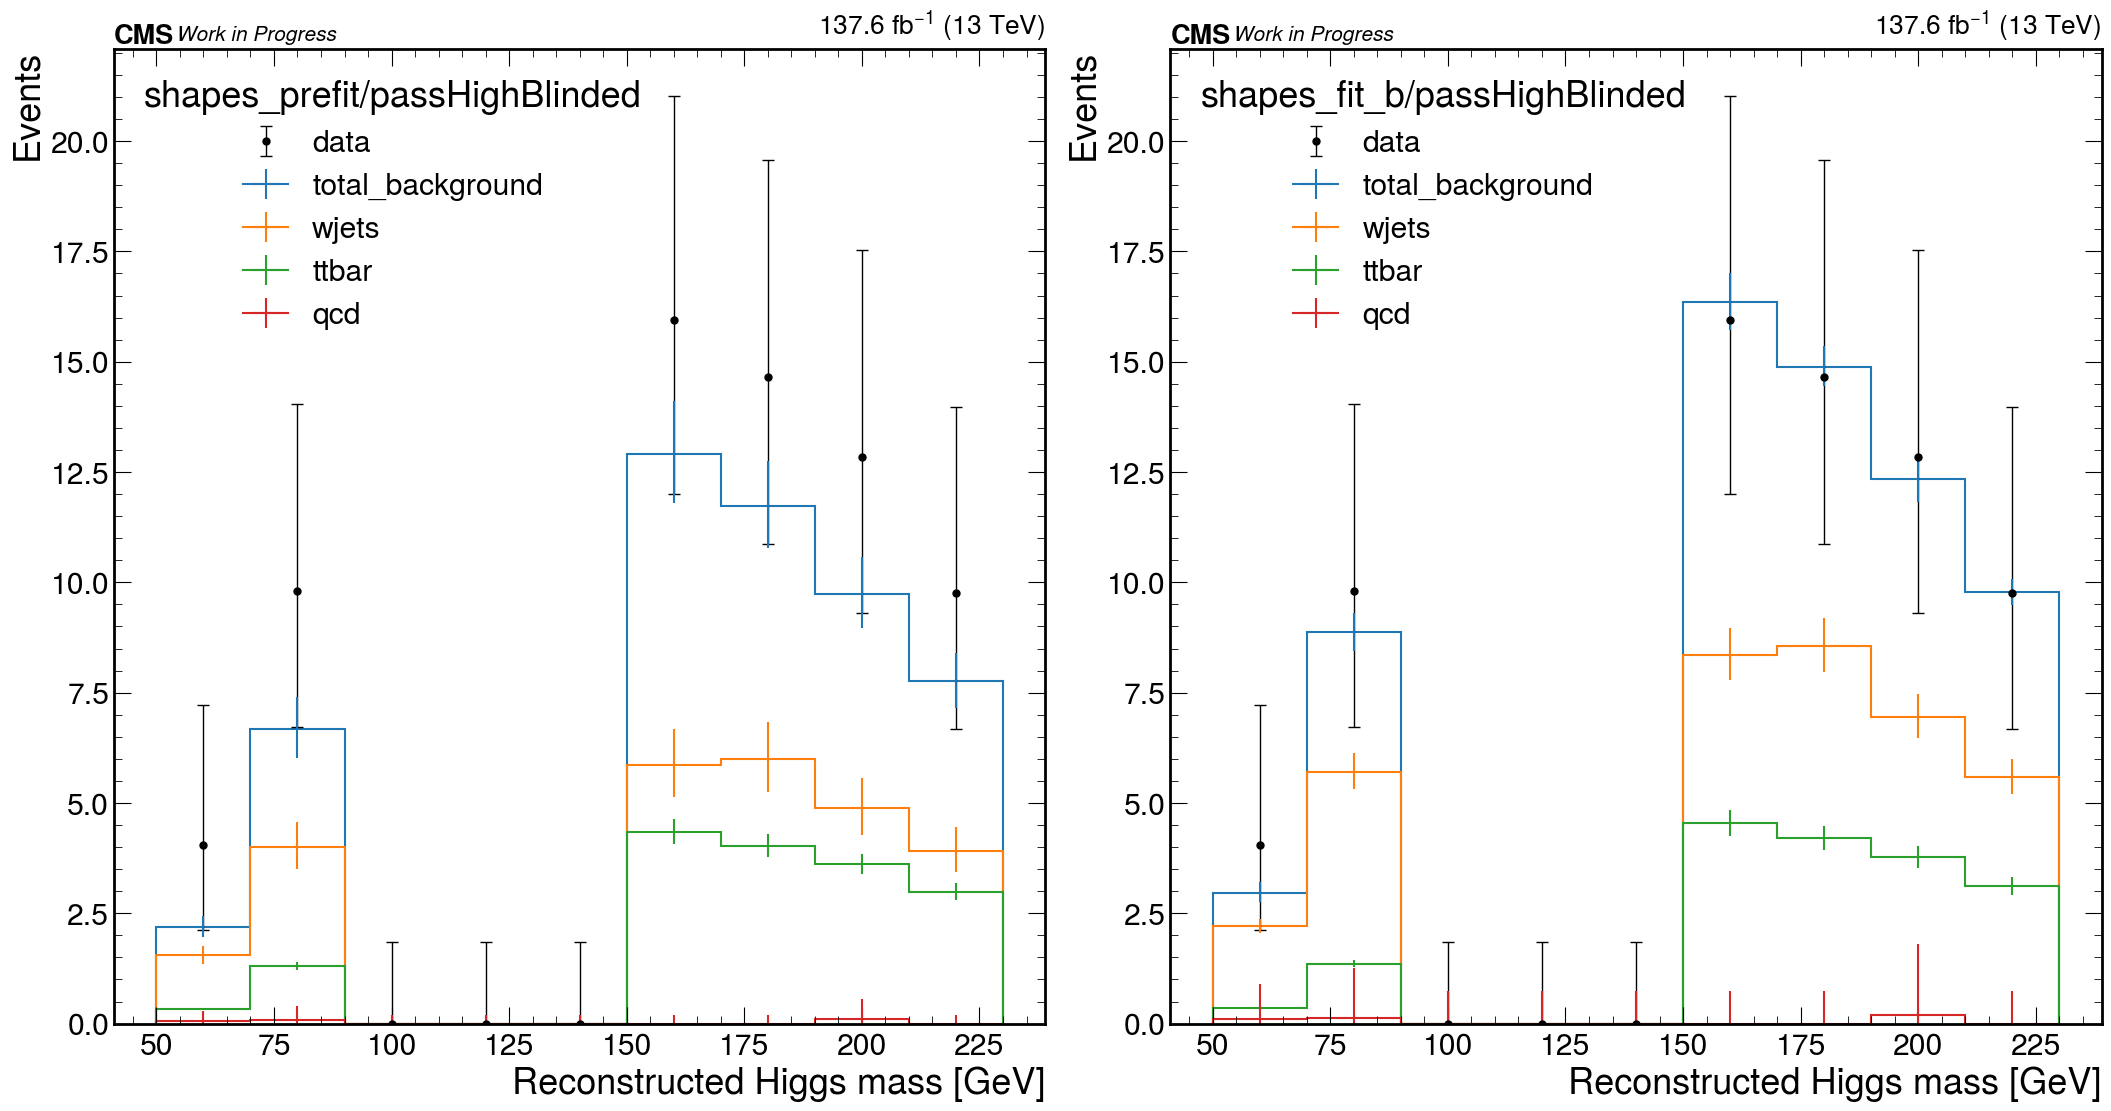

In [130]:
# region = "wjetsCR"
# region = "passMediumBlinded"
region = "passHighBlinded"

fig, axs = plt.subplots(1, 2, figsize=(21,11), constrained_layout=True)
for i, key in enumerate([f"shapes_prefit/{region}", f"shapes_fit_b/{region}"]):

    for sample in samples:
#         if "qcd" in sample:
#             if region == "passBlinded2":
#                 sample += f"_pass"
#             else:
#                 sample += f"_{region}"
            
        if sample == "data":
            
            hep.histplot(
                f[key]["data"].values()[1],
                bins=list(range(50, 240, 20)),
                ax=axs[i],
                label=sample,
                histtype="errorbar",
                color="k",
                capsize=4,           
            )   

        else:
#             if "qcd" in sample:
#                 lab = "QCD (data-driven)"
#             else:
#                 lab = sample
            lab = sample

            hep.histplot(             
                f[key][sample],
                ax=axs[i],
                histtype="step",
                label=lab,
            )    

    axs[i].legend(title=key, loc="upper left")
    axs[i].set_ylabel(f"Events")
    axs[i].set_xlabel(f"Reconstructed Higgs mass [GeV]")
    axs[i].set_ylim(0)   
    
    hep.cms.lumitext("%.1f " % full_lumi + r"fb$^{-1}$ (13 TeV)", ax=axs[i], fontsize=20)
    hep.cms.text("Work in Progress", ax=axs[i], fontsize=15)

plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku5/combine_bfit.pdf")        

In [17]:
samples = [
#     "data",
    "total_background",
    "total_signal",
#     "CMS_HWW_boosted_qcd_datadriven",
    "wjets",    
    "ttbar",
    "zjets",
    "singletop",
    "total_covar"
]

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Work in Progress'))

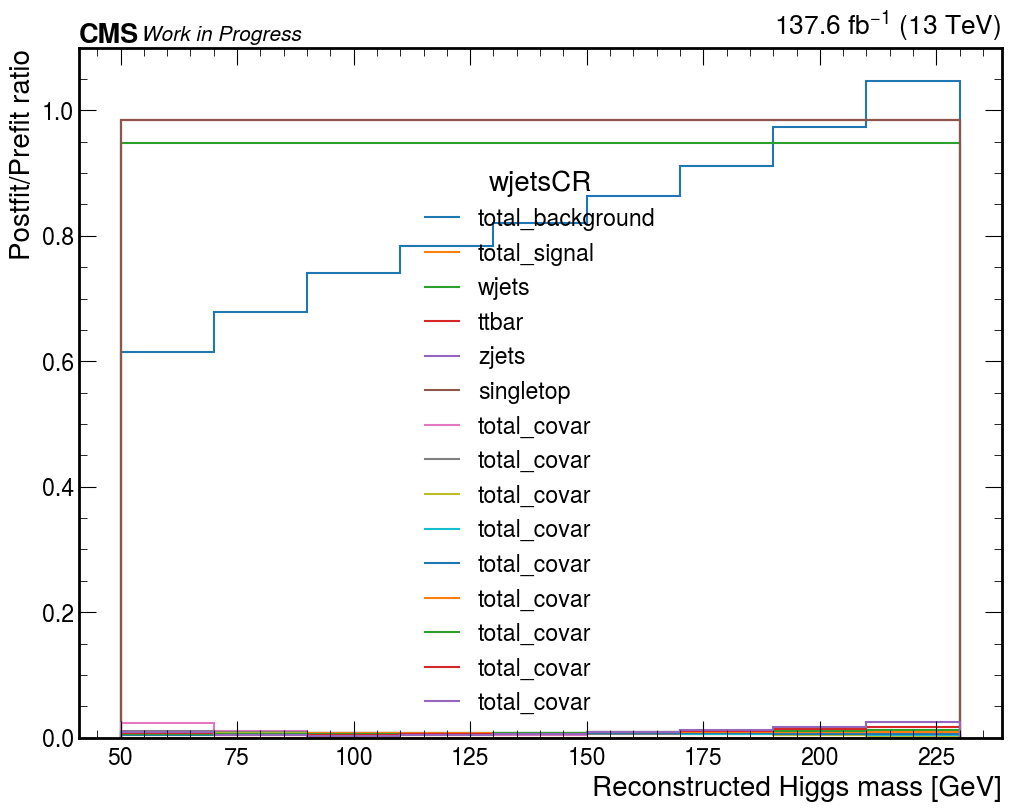

In [10]:
region = "wjetsCR"

if region=="pass":
    region += "Blinded"

fig, ax = plt.subplots(figsize=(10,8), constrained_layout=True)
for sample in samples:


    if sample == "data":
        num = f[f"shapes_fit_b/{region}"]["data"].values()[1]
        den = f[f"shapes_prefit/{region}"]["data"].values()[1]

        hep.histplot(
            num/den,
            bins=list(range(50, 240, 20)),
            ax=ax,
            label=sample,
            histtype="errorbar",
            color="k",
            capsize=4,           
        )   

    else:
        num = f[f"shapes_fit_b/{region}"][sample].values()
        den = f[f"shapes_prefit/{region}"][sample].values()

        hep.histplot(
            num/den,
            bins=list(range(50, 240, 20)),
            ax=ax,
            histtype="step",
            label=sample,
        )    

ax.legend(title=region)
ax.set_ylabel(f"Postfit/Prefit ratio")
ax.set_xlabel(f"Reconstructed Higgs mass [GeV]")
ax.set_ylim(0)    
hep.cms.lumitext("%.1f " % full_lumi + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)

In [428]:
f["shapes_prefit/passBlinded"]["wjets"].values()

array([1.4160691, 3.8754134, 0.       , 0.       , 0.       , 5.597086 ,
       5.7969   , 4.6152887, 3.6734428], dtype=float32)